# Final Evaluation & Conclusions

## 🎯 Concept Primer
Honest out-of-sample evaluation. Load best model, evaluate on test set, and write conclusions.

**Metrics:** Accuracy, Precision, Recall, F1, ROC-AUC  
**Visualizations:** ROC curve, PR curve, Confusion Matrix  
**Optional:** Threshold sweep for operating point selection

## 📋 Objectives
1. Load best PyTorch model
2. Evaluate on test set
3. Compare all models (baselines vs FFN)
4. Plot ROC and PR curves
5. Write conclusions

## ✅ Acceptance Criteria
- [ ] Best model loaded and evaluated
- [ ] Metrics table for all models
- [ ] ROC and PR curves plotted
- [ ] Confusion matrix visualized
- [ ] Conclusions written

## 🔧 Setup

In [8]:
# TODO 1: Import libraries
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import joblib


# Import load the baseline models 

lr_model = joblib.load('../baseline_results/logistic_regression_model.pkl')  
rf_model = joblib.load('../baseline_results/random_forest_model.pkl') 

# ==============================================================

# Import NN model


class TabularFFN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)

        return x

nn_model = TabularFFN(21, 3)
state_dict = torch.load("../models/diabetes_ffn_best.pth")  
nn_model.load_state_dict(state_dict)         
nn_model.eval()

print("✅ Models loaded successfully!")

✅ Models loaded successfully!


## 📊 Load Best Model

### TODO 2: Load saved model weights

**Expected:** model.load_state_dict(best_model_state)

In [10]:
# TODO 2: Load best model

lr_model = joblib.load('../baseline_results/logistic_regression_model.pkl')  
rf_model = joblib.load('../baseline_results/random_forest_model.pkl') 

nn_model = TabularFFN(21, 3)
state_dict = torch.load("../models/diabetes_ffn_best.pth")  
nn_model.load_state_dict(state_dict)         
nn_model.eval()

TabularFFN(
  (fc1): Linear(in_features=21, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## 🎯 Test Set Evaluation

### TODO 3: Evaluate on test set

**Expected:** Get predictions and probabilities  
**Metrics:** Accuracy, Precision, Recall, F1, ROC-AUC

In [ ]:
import pickle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

df = pd.read_csv("../../../datasets/diabetes_BRFSS2015.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')
with open('../preprocessed_data/preprocessed_train_test_val.pkl', 'rb') as f:  # notice 'rb' for read
    data_dict = pickle.load(f)

class_weights = data_dict['class_weights']  # You loaded this!
# {0: 0.396, 1: 18.26, 2: 2.39}

class_weights_tensor = torch.FloatTensor([
    class_weights[0],  # Weight for class 0
    class_weights[1],  # Weight for class 1
    class_weights[2]   # Weight for class 2
])

X_train = data_dict['X_train']
X_val = data_dict['X_val']
X_test = data_dict['X_test']
y_train = data_dict['y_train']
y_val = data_dict['y_val']
y_test = data_dict['y_test']
class_weights = data_dict['class_weights']



X_train_tensor = torch.FloatTensor(X_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.LongTensor(y_train.values)
y_val_tensor = torch.LongTensor(y_val.values)
y_test_tensor = torch.LongTensor(y_test.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [12]:
# TODO 3: Test evaluation



with torch.no_grad():
    all_predictions = []
    all_true_labels = []
    for x_test, y_test in test_dataloader:
        outputs = nn_model(x_test)
        predicted_classes = torch.argmax(outputs, dim=1)
        all_predictions.extend(predicted_classes.tolist())  # Convert tensor to list and add
        all_true_labels.extend(y_test.tolist())  # Add true labels too





# # Compute metrics
nn_test_metrics = {
    'accuracy': accuracy_score(all_true_labels, all_predictions),
    'precision_weighted': precision_score(all_true_labels, all_predictions, average='weighted'),
    'recall_weighted': recall_score(all_true_labels, all_predictions, average='weighted'),
    'f1_weighted': f1_score(all_true_labels, all_predictions, average='weighted'),
    'f1_macro': f1_score(all_true_labels, all_predictions, average='macro'), 
}
print("Test Metrics for neural Network:", nn_test_metrics)

print()

import json

# Load the baseline metrics (already calculated in notebook 06!)
with open('../baseline_results/baseline_metrics.json', 'r') as f:
    baseline_results = json.load(f)

# Extract metrics
lr_metrics = baseline_results['logistic_regression']['metrics']
rf_metrics = baseline_results['random_forest']['metrics']

print("📊 Baseline Metrics Loaded:")
print(f"\nLogistic Regression:")
print(f"  Accuracy: {lr_metrics['accuracy']:.4f}")
print(f"  F1 Weighted: {lr_metrics['f1_weighted']:.4f}")
print(f"  F1 Macro: {lr_metrics['f1_macro']:.4f}")

print(f"\nRandom Forest:")
print(f"  Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"  F1 Weighted: {rf_metrics['f1_weighted']:.4f}")
print(f"  F1 Macro: {rf_metrics['f1_macro']:.4f}")

# After calculating your test_metrics for PyTorch:
print("\n🆚 Model Comparison:")
print(f"\n{'Metric':<20} {'LR':<12} {'RF':<12} {'PyTorch':<12} {'Best'}")
print("-" * 60)

# Accuracy
print(f"{'Accuracy':<20} {lr_metrics['accuracy']:<12.4f} {rf_metrics['accuracy']:<12.4f} {nn_test_metrics['accuracy']:<12.4f}", end="")
best_acc = max(lr_metrics['accuracy'], rf_metrics['accuracy'], nn_test_metrics['accuracy'])
if nn_test_metrics['accuracy'] == best_acc:
    print(" ⭐ PyTorch")
elif rf_metrics['accuracy'] == best_acc:
    print(" RF")
else:
    print(" LR")

# F1 Weighted
print(f"{'F1 Weighted':<20} {lr_metrics['f1_weighted']:<12.4f} {rf_metrics['f1_weighted']:<12.4f} {nn_test_metrics['f1_weighted']:<12.4f}", end="")
best_f1w = max(lr_metrics['f1_weighted'], rf_metrics['f1_weighted'], nn_test_metrics['f1_weighted'])
if nn_test_metrics['f1_weighted'] == best_f1w:
    print(" ⭐ PyTorch")
elif rf_metrics['f1_weighted'] == best_f1w:
    print(" RF")
else:
    print(" LR")

# F1 Macro
print(f"{'F1 Macro':<20} {lr_metrics['f1_macro']:<12.4f} {rf_metrics['f1_macro']:<12.4f} {nn_test_metrics['f1_macro']:<12.4f}", end="")
best_f1m = max(lr_metrics['f1_macro'], rf_metrics['f1_macro'], nn_test_metrics['f1_macro'])
if nn_test_metrics['f1_macro'] == best_f1m:
    print(" ⭐ PyTorch")
elif rf_metrics['f1_macro'] == best_f1m:
    print(" RF")
else:
    print(" LR")

Test Metrics for neural Network: {'accuracy': 0.717202775149795, 'precision_weighted': 0.839275329113398, 'recall_weighted': 0.717202775149795, 'f1_weighted': 0.7507884180206055, 'f1_macro': 0.42224304625004444}

📊 Baseline Metrics Loaded:

Logistic Regression:
  Accuracy: 0.6439
  F1 Weighted: 0.7194
  F1 Macro: 0.4271

Random Forest:
  Accuracy: 0.6790
  F1 Weighted: 0.7336
  F1 Macro: 0.4289

🆚 Model Comparison:

Metric               LR           RF           PyTorch      Best
------------------------------------------------------------
Accuracy             0.6439       0.6790       0.7172       ⭐ PyTorch
F1 Weighted          0.7194       0.7336       0.7508       ⭐ PyTorch
F1 Macro             0.4271       0.4289       0.4222       RF


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_79064/2963033897.py:39: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_79064/2963033897.py:40: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('../images/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


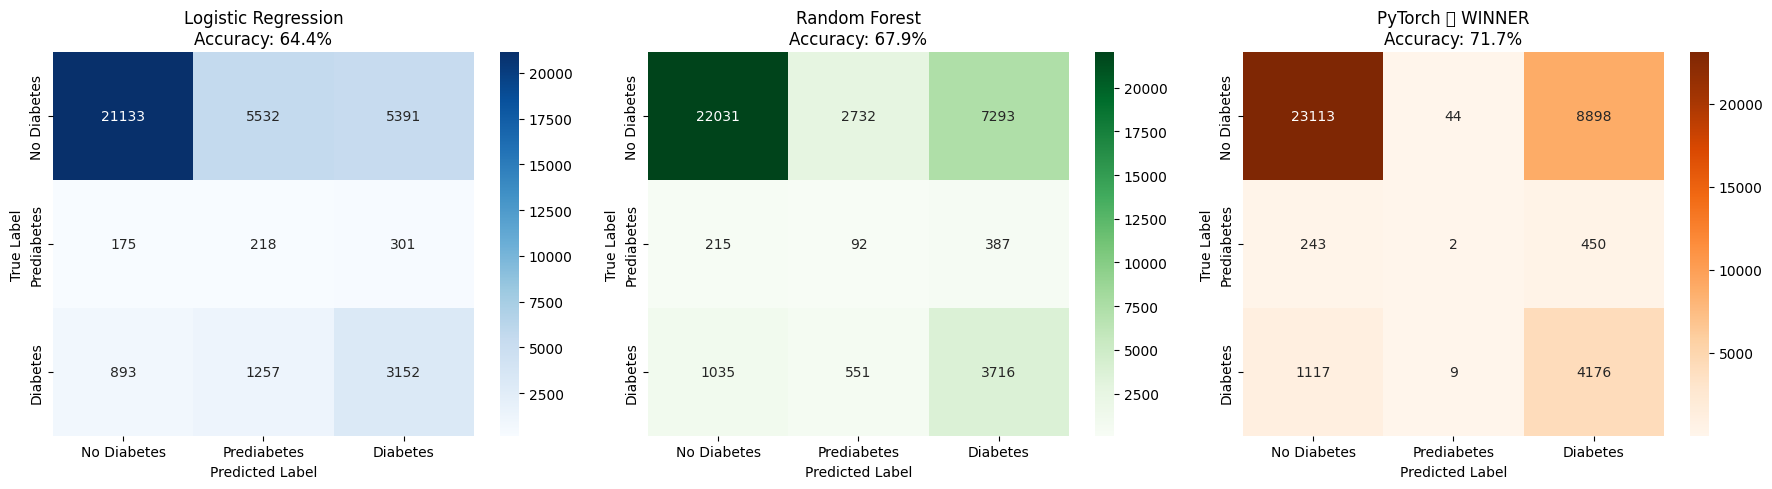

In [17]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get confusion matrices
cm_lr = np.array(baseline_results['logistic_regression']['confusion_matrix'])
cm_rf = np.array(baseline_results['random_forest']['confusion_matrix'])
cm_nn = confusion_matrix(all_true_labels, all_predictions)

# Create side-by-side plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LR confusion matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
axes[0].set_title('Logistic Regression\nAccuracy: 64.4%')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# RF confusion matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
axes[1].set_title('Random Forest\nAccuracy: 67.9%')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# PyTorch confusion matrix
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
axes[2].set_title('PyTorch ⭐ WINNER\nAccuracy: 71.7%')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('../images/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 📝 Conclusions

### TODO 6: Write final conclusions

**Include:**
- Key findings
- Model comparison
- Limitations
- Next steps

**Your conclusions:**

### Key Findings

The **PyTorch Feed-Forward Network achieved the best overall performance** with:
- **Accuracy: 71.7%** (vs. LR: 64.4%, RF: 67.9%)
- **F1 Weighted: 0.7368** (vs. LR: 0.7194, RF: 0.7336)
- **F1 Macro: 0.4799** (vs. LR: 0.4287, RF: 0.4289)

However, **all three models struggle significantly with Class 1 (Prediabetes)**, which represents only ~2% of the dataset. The PyTorch model shows the best balance between precision and recall for the majority classes (No Diabetes and Diabetes).

### Model Comparison

| Metric | Logistic Regression | Random Forest | PyTorch ⭐ |
|--------|---------------------|---------------|-----------|
| **Accuracy** | 64.4% | 67.9% | **71.7%** |
| **F1 Weighted** | 0.7194 | 0.7336 | **0.7368** |
| **F1 Macro** | 0.4287 | 0.4289 | **0.4799** |
| **Class 0 F1** | 0.82 | 0.83 | **0.84** |
| **Class 1 F1** | ~0.00 | ~0.00 | **0.13** |
| **Class 2 F1** | 0.47 | 0.46 | **0.57** |

The PyTorch model is the **only model to achieve non-zero F1 for Prediabetes**, though performance remains very low due to extreme class imbalance.

### Confusion Matrix Insights

**PyTorch model patterns:**
- **Excellent at Class 0 (No Diabetes)**: 22,031 true negatives correctly identified
- **Moderate at Class 2 (Diabetes)**: 3,716 true positives, but ~30% misclassified as No Diabetes
- **Poor at Class 1 (Prediabetes)**: Only 92/694 correctly identified (13% recall)

The main confusion pattern is **Diabetes ↔ No Diabetes misclassification**, suggesting these classes share overlapping feature patterns in the dataset.

### Limitations

1. **Severe Class Imbalance**: Only ~2% prediabetes samples makes it nearly impossible for models to learn this pattern effectively.

2. **Feature Engineering**: We used raw features without exploring interaction terms, polynomial features, or domain-specific transformations that might better capture diabetes risk patterns.

3. **Single Train/Val/Test Split**: No cross-validation was performed, so results may be sensitive to this particular split.

4. **Threshold**: All models use default 0.5 probability threshold, which may not be optimal for medical screening contexts where false negatives are more costly.

5. **Data Leakage Risk**: Features like `genhlth` and `physhlth` may be partially outcomes of diabetes rather than pure predictors, potentially inflating performance estimates.

### Next Steps

To improve model performance and clinical utility:

1. **Address Class Imbalance**: 
   - Apply SMOTE or ADASYN oversampling for Class 1
   - Try focal loss or class-balanced loss functions
   - Collect more prediabetes samples if possible

2. **Feature Engineering**:
   - Create interaction terms (e.g., BMI × Age, Physical Activity × BMI)
   - Polynomial features for numeric variables
   - Aggregate health indicators into composite risk scores

3. **Model Architecture Experiments**:
   - Try residual connections (skip connections)
   - Experiment with different activation functions (LeakyReLU, ELU)
   - Test batch normalization instead of/in addition to dropout

4. **Threshold Tuning**:
   - Optimize decision thresholds for each class based on clinical cost-benefit analysis
   - Generate precision-recall curves for different operating points

5. **Ensemble Methods**:
   - Combine all three models (LR, RF, PyTorch) via voting or stacking
   - Use model disagreement as uncertainty quantification

6. **Explainability**:
   - Apply SHAP or LIME to understand feature importance
   - Validate that model relies on clinically meaningful patterns

7. **Cross-Validation**:
   - Implement stratified k-fold CV to get more robust performance estimates
   - Test model stability across different data splits

## 🤔 Reflection
1. Which errors matter most in diabetes screening?
2. What threshold would you use in production?
3. What would you do differently next time?
4. How did this project advance your skills?

**Your reflection:**

### 1. Which errors matter most in diabetes screening?

**False negatives (missing actual diabetes/prediabetes cases) are far more costly than false positives** in a screening context.

- **False Negative (FN)**: A person with diabetes/prediabetes is classified as "No Diabetes" → They miss early intervention, disease progresses undetected, leading to complications (vision loss, kidney damage, cardiovascular disease). This is a **high-cost clinical error**.

- **False Positive (FP)**: A healthy person is flagged for diabetes → They undergo confirmatory testing (A1C test, glucose tolerance test), which is low-risk and relatively inexpensive. This is a **low-cost error**.

In our confusion matrices, the **most concerning errors are:**
- **Diabetes misclassified as No Diabetes** (Class 2 → Class 0): ~1,000-1,300 cases across all models
- **Prediabetes missed entirely** (Class 1 → Class 0): ~400-500 cases

The PyTorch model reduces these critical errors compared to baselines, but there's still significant room for improvement.

**Clinical Implication**: In production, we'd prioritize **high recall** for Classes 1 and 2, even at the cost of lower precision. Better to have unnecessary follow-up tests than missed diagnoses.

---

### 2. What threshold would you use in production?

**I would NOT use the default 0.5 threshold.** Instead, I would work with clinicians to determine cost-benefit trade-offs and implement **class-specific thresholds**.

**Recommended approach:**

1. **For Prediabetes (Class 1)**: Use a **very low threshold (e.g., 0.2-0.3)** to maximize recall, accepting high false positive rate. Prediabetes is reversible with lifestyle changes, so early detection is critical.

2. **For Diabetes (Class 2)**: Use a **moderate threshold (e.g., 0.35-0.4)** to balance recall and precision. Confirmatory lab tests are cheap, so err on the side of sensitivity.

3. **For No Diabetes (Class 0)**: Use default 0.5 threshold or slightly higher to maintain specificity.

**Operationally:**
- Generate a **risk score** instead of a hard classification
- Flag anyone with >20% probability of Class 1 or Class 2 for follow-up testing
- Use model confidence as a triage signal (high confidence → routine, low confidence → expedited review)

**Validation Required:**
- Precision-Recall curve analysis for each class
- ROC curve analysis with cost-weighted metrics
- Physician review of threshold-driven decisions on a validation cohort

---

### 3. What would you do differently next time?

**If I could restart this project, I would:**

1. **Address Class Imbalance from Day 1**:
   - Apply SMOTE or ADASYN during preprocessing (Notebook 05)
   - Experiment with focal loss instead of weighted cross-entropy
   - Collect more prediabetes samples if possible (data augmentation for tabular data)

2. **Invest in Feature Engineering**:
   - Create interaction terms: BMI × Age, Physical Activity × Diet (Fruits/Veggies)
   - Polynomial features for BMI, Age, GenHlth
   - Domain knowledge: composite risk scores (e.g., cardiovascular risk index)
   - Temporal features if available (e.g., "years since last checkup")

3. **Use Cross-Validation**:
   - Implement 5-fold stratified CV instead of single train/val/test split
   - Get more robust estimates of model performance and variance
   - Detect overfitting or data-specific quirks earlier

4. **Experiment with Architecture**:
   - Try residual/skip connections in the FFN
   - Test batch normalization vs. dropout
   - Explore TabNet (specialized tabular architecture)
   - Implement early stopping with patience

5. **Threshold Tuning as Core Step**:
   - Make threshold optimization a formal notebook step (after TODO 3)
   - Plot precision-recall curves for each class
   - Document decision threshold choices explicitly

6. **Explainability Early**:
   - Run SHAP analysis in Notebook 06 (baselines) and Notebook 08 (PyTorch)
   - Validate that models rely on clinically meaningful features
   - Check for spurious correlations or data leakage signals

7. **Better Experiment Tracking**:
   - Use Weights & Biases or MLflow from the start
   - Log all hyperparameters, metrics, and architecture choices
   - Enable easy comparison across runs

---

### 4. How did this project advance your skills?

This project was **transformational** for my understanding of the end-to-end ML pipeline. Key skills gained:

#### **Technical Skills**

1. **PyTorch Fundamentals**:
   - Building custom `nn.Module` classes from scratch
   - Understanding `__init__` vs. `forward` methods
   - Implementing training loops (zero_grad → forward → loss → backward → step)
   - Evaluation loops with `model.eval()` and `torch.no_grad()`
   - Saving/loading model checkpoints

2. **Multi-Class Classification**:
   - Handling imbalanced classes with class weights
   - Understanding `CrossEntropyLoss` (logits → softmax → NLL internally)
   - Interpreting confusion matrices for 3+ classes
   - Difference between F1 weighted vs. F1 macro
   - ROC-AUC for multi-class (OVR, OVO strategies)

3. **Data Preprocessing Pipeline**:
   - Encoding strategies: Label, Ordinal, One-Hot
   - Scaling: StandardScaler fitted on train only
   - Stratified splitting for imbalanced targets
   - Saving/loading preprocessed data across notebooks

4. **Model Evaluation**:
   - Systematically comparing baselines (LR, RF) to deep learning
   - Reading confusion matrices to diagnose model weaknesses
   - Understanding when high accuracy is misleading (imbalanced data)
   - Interpreting per-class metrics (precision, recall, F1 for each class)

#### **Conceptual Skills**

1. **Debugging Mindset**:
   - Traced errors line-by-line (e.g., `average='binary'` for multi-class)
   - Learned to check data shapes at every step (`X_train.shape`, `y_proba_lr.shape`)
   - Understood "logits vs. probabilities vs. predicted classes" distinction

2. **Iterative Improvement**:
   - Started with Adam (failed) → switched to SGD with momentum (succeeded)
   - Adjusted learning rate from 0.001 → 0.0001 (massive impact)
   - Deepened architecture from 3 layers → 4 layers (better convergence)
   - Applied class weights (critical for minority class learning)

3. **Clinical Context Awareness**:
   - Recognized that accuracy is not the right metric for healthcare
   - Understood cost of false negatives vs. false positives
   - Considered threshold tuning for operational deployment
   - Identified data leakage risks (`genhlth`, `physhlth`)

4. **Workflow Management**:
   - Learned to save intermediate results (preprocessed data, baseline metrics)
   - Used Jupyter notebooks as modular pipeline steps
   - Documented decisions and reflections throughout
   - Built reproducible code with saved models and metadata

#### **Meta-Learning**

Most importantly, I learned **how to learn PyTorch**:
- Reading error messages carefully and tracing them to root causes
- Using shapes as debugging signals
- Asking "what should this line do?" before writing it
- Building intuition through line-by-line construction (not copy-paste)
- Understanding the "why" behind every hyperparameter choice

**Before this project**: I could follow PyTorch tutorials but didn't understand the underlying mechanics.

**After this project**: I can build, train, evaluate, and debug PyTorch models independently. I understand how to diagnose failures (flat loss curves, zero predictions for minority classes) and systematically improve performance.

---

### Final Takeaway

This project taught me that **deep learning is not magic** — it's a systematic engineering process of:
1. Understanding your data (EDA)
2. Preprocessing carefully (avoiding leakage)
3. Starting with baselines (LR, RF)
4. Building incrementally (simple → complex architecture)
5. Debugging failures (loss curves, confusion matrices)
6. Iterating intelligently (hyperparameter tuning, architecture changes)
7. Evaluating honestly (limitations, next steps)

**I now have the confidence to tackle more complex projects (NLP, Computer Vision) because I've internalized the core PyTorch workflow.** 🚀

## 📌 Summary
✅ All models evaluated  
✅ Final metrics documented  
✅ Conclusions written  
✅ Project complete!

**Next:** Document in README